<center>
<img src="logo.png" height="900"> 
</center>


# Максимально правдоподобная домашка

В этом задании мы с вами отточим метод максимального правдоподобия.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Упражнение 1 (Разминка)

__а)__ Пусть $X \sim Exp(0.05)$. Сгенерируйте из этого распределения выборку размера $1000$. У метода `rvs` используйте `random_state=42` 

Обратите внимание, что `stats.expon` принимает в качестве параметра `scale` значение $\frac{1}{\lambda}$, а $0.05$ это именно $\lambda$.

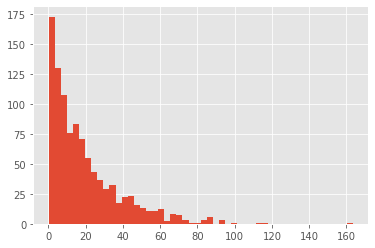

In [2]:
x = stats.expon(scale=1/0.05).rvs(1000, random_state=42)
plt.hist(x, bins=50);

In [3]:
assert np.abs(19.45 - np.mean(x)) < 0.01

__б)__ Выпишите логарифмическую функцию правдоподобия на бумажке. Затем вбейте её в python.

In [4]:
def lnL(theta, x):
    l = len(x) * np.log(theta) - theta * np.sum(x)
    return -l

In [5]:
assert np.abs(lnL(4, x) - 76414.1814) < 1e-4

# несколько похожих скрытых тестов

__в)__ Оцените значение параметра $\lambda$ по сгенерированной выборке `x`. Аккуратнее выбирайте точку для инициализации параметра. 

In [6]:
theta_init = 0.0005
res = minimize(lnL, theta_init, args=x)
res

      fun: 3967.853186205376
 hess_inv: array([[2.64335116e-06]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 9
     njev: 15
   status: 0
  success: True
        x: array([0.05141356])

In [7]:
assert np.abs(res.x[0] - 0.0514) < 1e-4

# несколько похожих скрытых тестов

__г)__ Постройте график для функции правдоподобия. По оси $x$ отложите значения $\lambda$, по оси $y$ логарифм правдоподобия. Отметьте на картинке точку оптимума. 

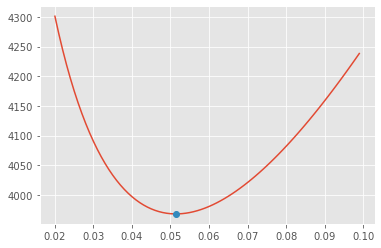

In [8]:
lam = np.arange(0.02, 0.1, 0.001)
plt.plot(lam, lnL(lam, x))
plt.plot(res.x[0], lnL(res.x[0], x), 'o');

__д)__ Постройте для параметра $\lambda$ асимптотический $80\%$ доверительный интервал. 

In [9]:
alpha = 0.2
z = stats.norm.ppf(1-alpha/2)

left = res.x[0] - z*np.sqrt(res.hess_inv[0,0])
right = res.x[0] + z*np.sqrt(res.hess_inv[0,0])

In [10]:
left, right

(0.049329963797879205, 0.053497155808932)

In [11]:
assert np.abs(z - 1.2815) < 1e-4

# несколько похожих скрытых тестов

__е)__ Проверите на уровне значимости $1\%$ тестом отношения правдоподобия гипотезу о том, что $\lambda = 0.05$. 

In [12]:
alpha = 0.01
lnL_un = res.fun
lnL_r = lnL(0.05, x)

LR_obs = 2 * (lnL_r - lnL_un)
print(LR_obs)

LR_cr = stats.chi2(df=1).ppf(1-alpha)
print(LR_cr)

0.7700706276791607
6.6348966010212145


In [13]:
assert np.abs(lnL_un - 3967.8531) < 1e-4

# несколько похожих скрытых тестов

Справились? Значит вас ничто не может остановить реализовать подобный пайплайн для более сложной ситуации. Убедитесь в этом сами, решив задачку про «Челленджер».

## Упражнение 2 (Логистическая регрессия)

В этом упражнении мы оценим методом максимального правдоподобия логистическую регрессию.

$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [14]:
df = pd.read_csv('challenger.csv', sep=',')
print(df.shape)
df.head()

(23, 3)


,Date,Temperature,Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,01/11/1982,68,0
4,04/04/1983,67,0


__а)__ Постройте на графиках гистограмму для распределения температуры $(Temperature)$ в ситуациях, когда хотябы одно кольцо было повреждено $(Incident = 1)$ и в ситуациях, когда ни одного повреждения не было $(Incident = 0)$. 

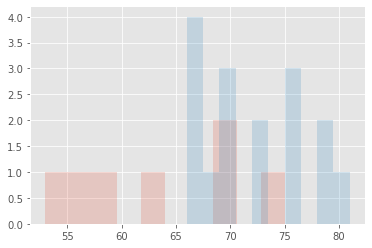

In [15]:
df[df['Incident'] == 1].Temperature.hist(alpha=0.2);
df[df['Incident'] == 0].Temperature.hist(alpha=0.2);

In [16]:
df[df['Incident'] == 1].Temperature.mean(), df[df['Incident'] == 0].Temperature.mean()

(63.714285714285715, 72.125)

__б)__ Судя по всему, между температурой и вероятностью поломки есть взаимосвязь. Пусть вероятность поломки зависит от температуры экспоненциально:
    
$$
P(Incident = 1) = \frac{e^{\alpha + \beta \cdot t}}{1 + e^{\alpha + \beta \cdot t}} = \frac{1}{1 + e^{-1\cdot(\alpha + \beta \cdot t)}} 
$$
    
Выведите функцию правдоподобия и задачу для оптимизации поиска коэффициентов $\alpha$ и  $\beta$ на бумажке, а затем вбейте её в python. 

In [17]:
def lnL(theta, data):
    a, b = theta
    temp_0 = df[df['Incident'] == 0].Temperature
    temp_1 = df[df['Incident'] == 1].Temperature
    
    theta_0 = a + b * temp_0
    theta_1 = a + b * temp_1
    return (np.sum(np.log(1 + np.exp(-theta_1))) - np.sum(np.log(1 - 1 / (1 + np.exp(-theta_0)))))

In [18]:
assert np.abs(lnL([4, 0.2], df) - 294.8) < 1e-4

# несколько похожих скрытых тестов

__в)__ Оцените параметры $\alpha$ и $\beta$ с помощью метода максимального правдоподобия.

In [19]:
theta_init = [0, 0]
res = minimize(lnL, theta_init, args=df)
res

      fun: 10.15759634399728
 hess_inv: array([[ 5.33002127e+01, -7.79464940e-01],
       [-7.79464940e-01,  1.14648416e-02]])
      jac: array([-4.76837158e-07, -2.98023224e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 144
      nit: 14
     njev: 44
   status: 2
  success: False
        x: array([15.0429846 , -0.23216397])

In [20]:
assert np.abs(res.fun - 10.1576) < 1e-4

# несколько похожих скрытых тестов

__г)__ С помощью теста отношения правдоподобий на уровне значимости $5\%$ проверьте гипотезу о том, что $\alpha = \beta = 0$.

In [21]:
alpha = 0.01
lnL_un = res.fun
lnL_r = lnL([0, 0], df)

LR_obs = 2 * (lnL_r - lnL_un)
LR_crit = stats.chi2(df=2).ppf(0.95)

# your code here

In [22]:
assert np.abs(lnL_un - 10.1576) < 1e-4

# несколько похожих скрытых тестов

__д)__ В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. Предскажите с помощью построенной модели вероятность катастрофы (для этого подставьте в формулу поиска вероятности получившиеся оценки и температуру).

In [23]:
xnew = 31
alpha, beta = res.x
p_hat = 1 / (1 + np.exp(-(alpha + beta * xnew)))

In [24]:
assert np.abs(p_hat - 0.9996) < 1e-4

# несколько похожих скрытых тестов

Только что мы с вами оценили логистическую регрессию. На самом деле функцию потерь, которую обычно используют для оценки логистической регрессии (logloss) можно получить из метода максимального правдоподобия. Об этом мы поговорим на следующей неделе нашего курса. 

__е)__ А сейчас, давайте сделаем финальный штрих и оценим ту же самую моделю с помощью пакета `statsmodels`.

In [25]:
import statsmodels.formula.api as smf

model = smf.logit(data=df, formula='Incident ~ 1 + Temperature').fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Incident   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Sun, 24 Jul 2022   Pseudo R-squ.:                  0.2813
Time:                        14:26:23   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0429      7.379      2.039      0.041       0.581      29.505
Temperature    -0.2322      0.108     -2.145      0.032      -0.444      -0.020
===============================================================================
"""

Посмотрев на протокол, получившийся в результате оценивания модели ответьте на вопросы: 

- Чему равноо значение логарифма правдоподобия? Запишите это значение в `logLik`
- Чему равна оценка константы $\alpha$? Запишите это значение в `alph`
- По свойствам метода максимального правдоподобия $\hat{\beta} \sim N(\beta, \hat{\sigma}^2_{\beta})$, чему равно значение $\hat{\sigma}_{\beta}$? Запишите это значение в `std_beta`
- Чему равно p-значение для гипотезы $H_0: \beta = 0$? Запишите это значение в `pval_beta`
- Отвергается ли гипотеза $H_0: \beta = 0$ на $5\%$ уровне значимости? Если да, запишите в `is_h` значение `False`

In [26]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

logLik = -10.158
alph = 15.0429
std_beta = 0.108
pval_beta = 0.032
is_h = False

# your code here

In [27]:
assert np.abs(logLik + 10.158) < 1e-4

# несколько похожих скрытых тестов